In [1]:
import os, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
TABLES_DIRECTORY = "../../Data/giant_new_tables"

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    # 165, # incomplete data
    # 169, # not enough time after the last seizure
    173,
    # 150, # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207, # not enough time before first seizure
    223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    177,
    185,
    # 189, # not enough time before first seizure
    # 205, # not enough time before first seizure
    166,
    # 170, # not enough time before first seizure
    # 174, # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
def plot_stuff(hourly_patient_features_df, hup_id):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    # Plotting Individual ASMs
    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(hourly_patient_features_df["emu_minute"], normalized_data)

    seizure_minutes = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_minute"].values
    for idx in seizure_minutes:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Load")
    ax[0].set_ylim([0, 1.3])
    ax[0].set_title("Individual ASMs")

    ax[1].plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")

    # Plotting synchrony (broadband Band)
    ax[2].plot(
        hourly_patient_features_df["emu_minute"],
        hourly_patient_features_df["synchrony_broadband"],
    )
    ax[2].set_ylabel("Synchrony")
    ax[2].set_title("Synchrony (broadband band)")

    ax[2].set_xlabel("Time (minutes)")

    fig.suptitle(f"HUP {hup_id}")

    plt.tight_layout()
    plt.show()

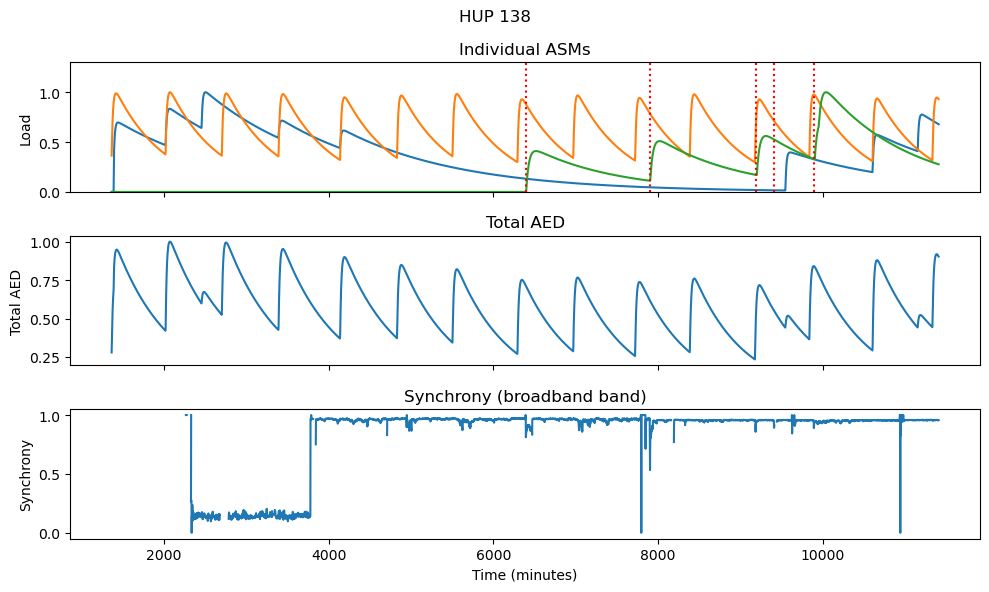

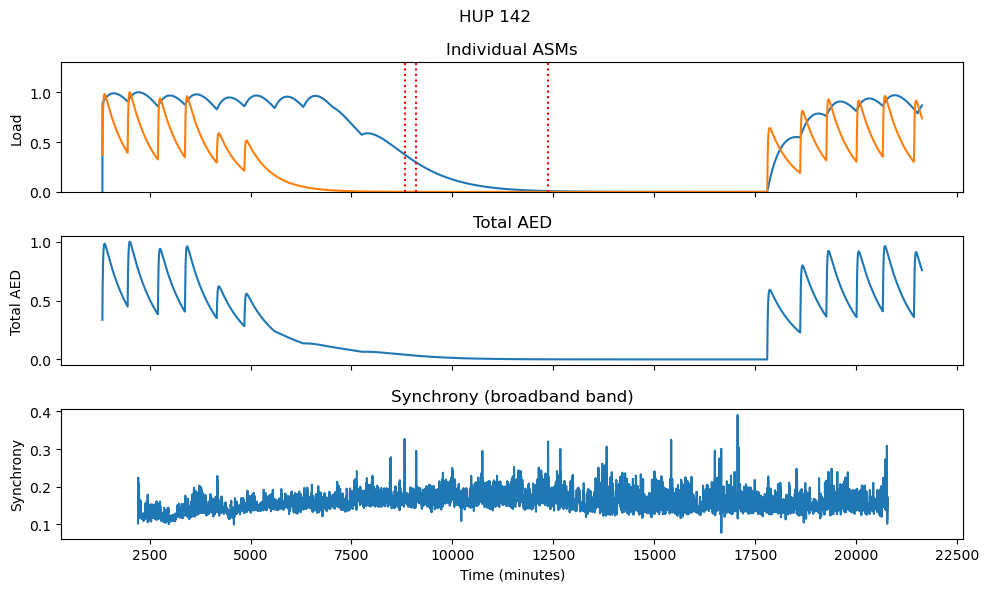

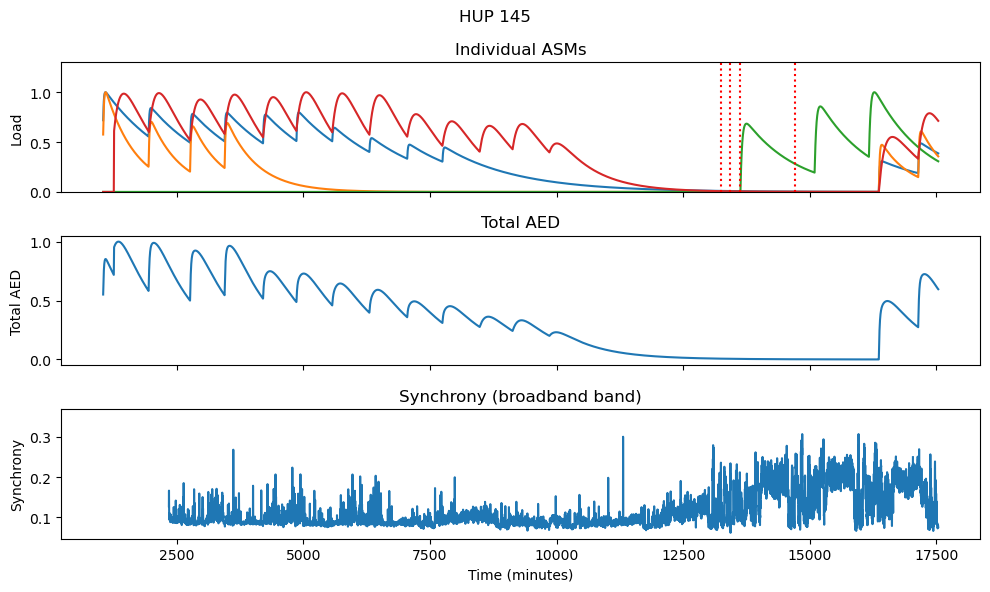

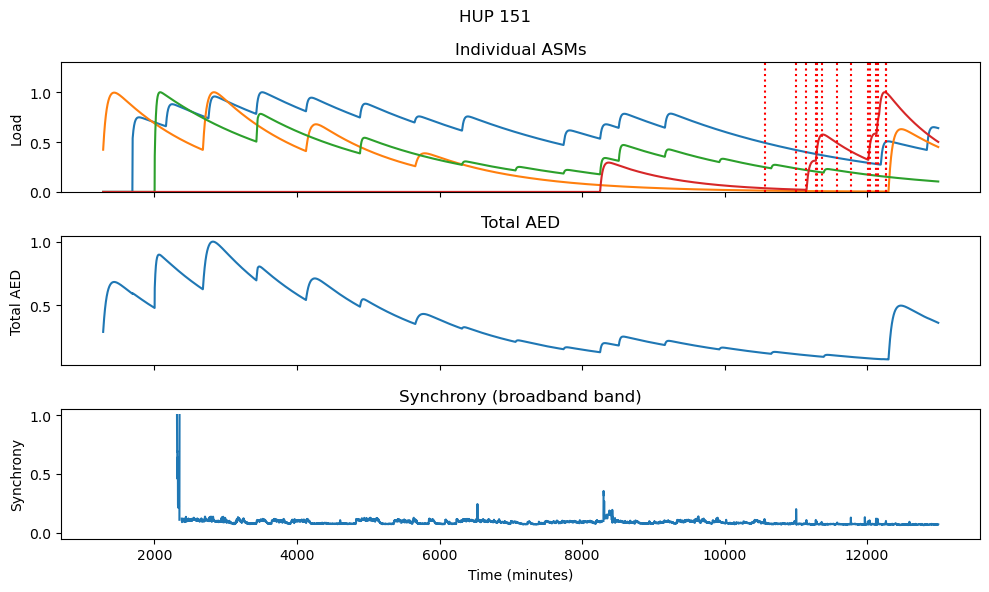

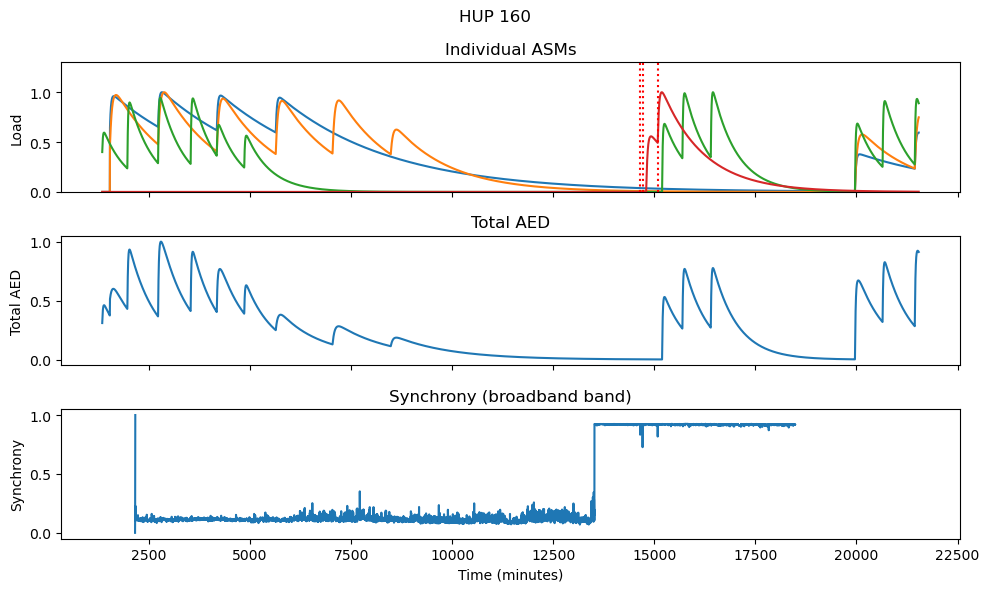

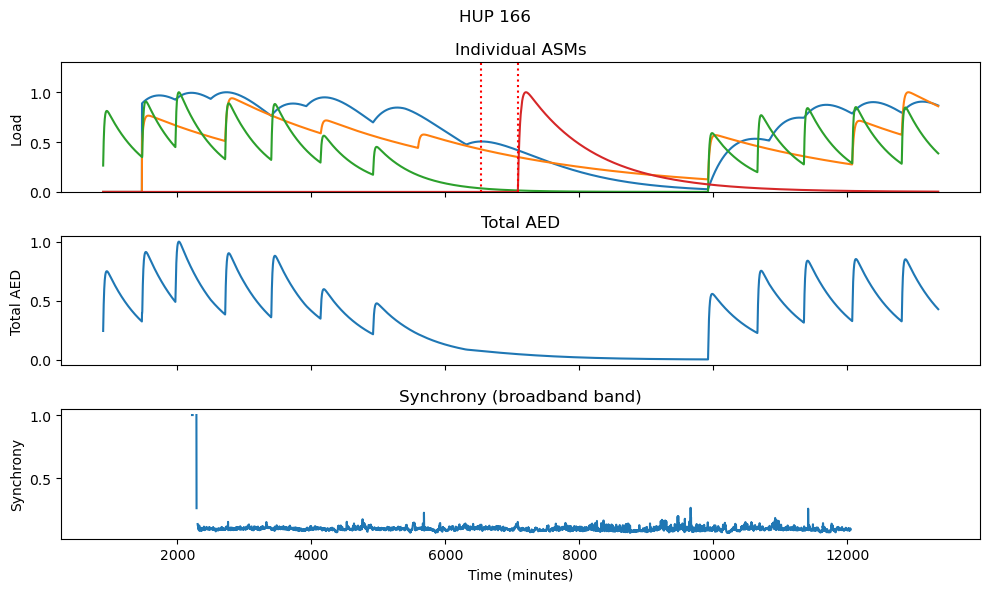

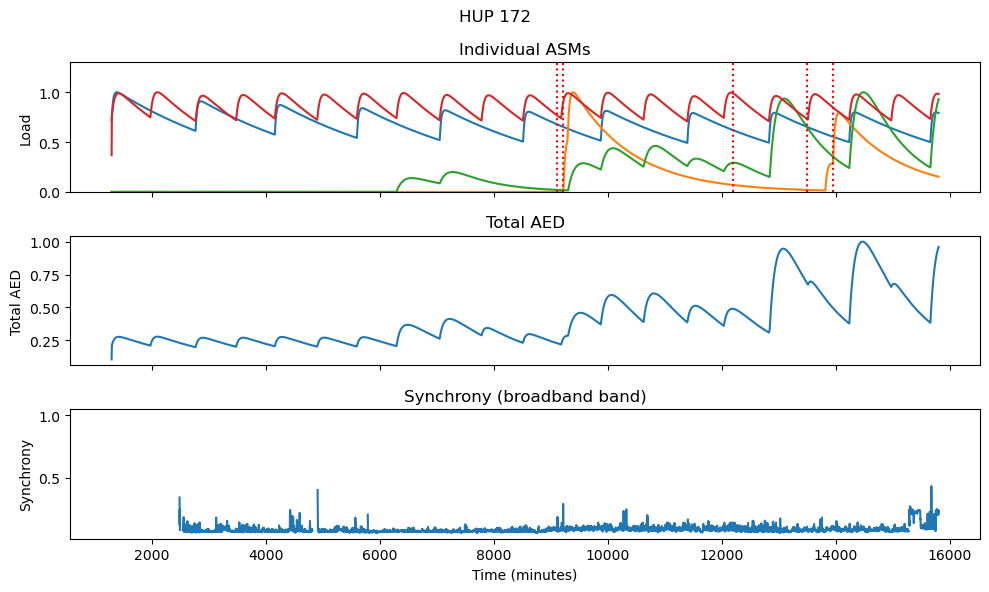

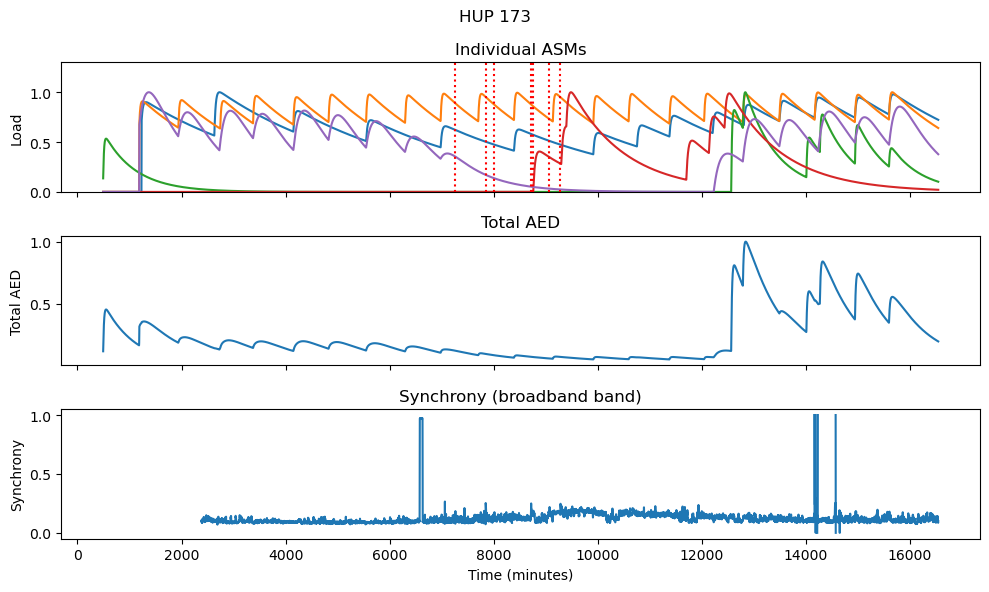

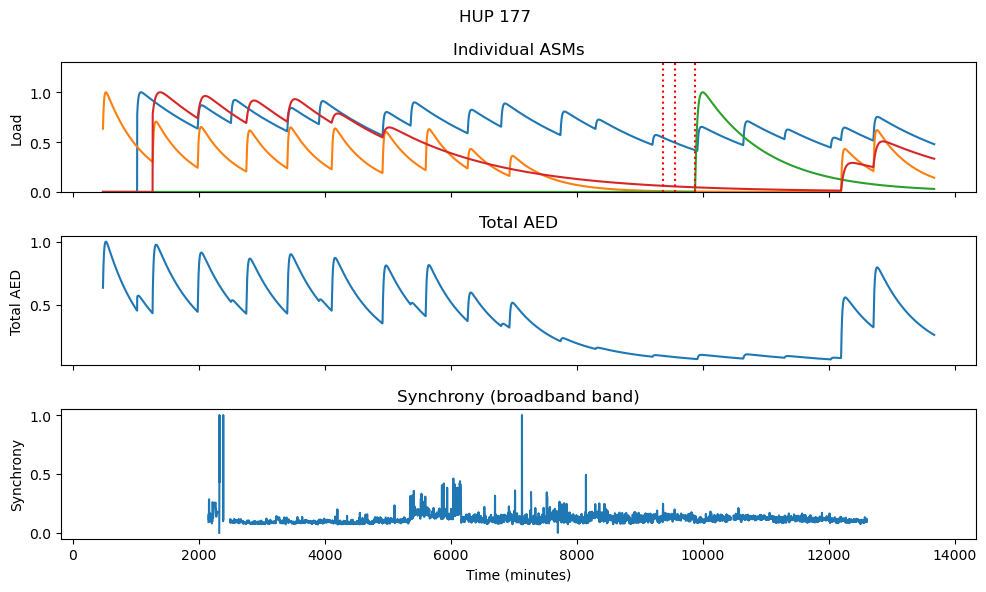

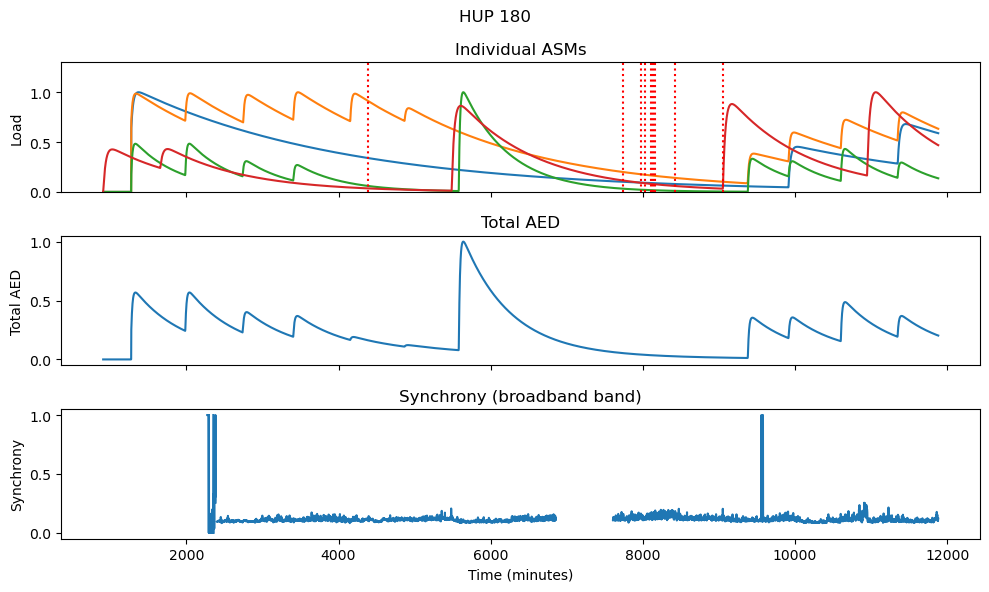

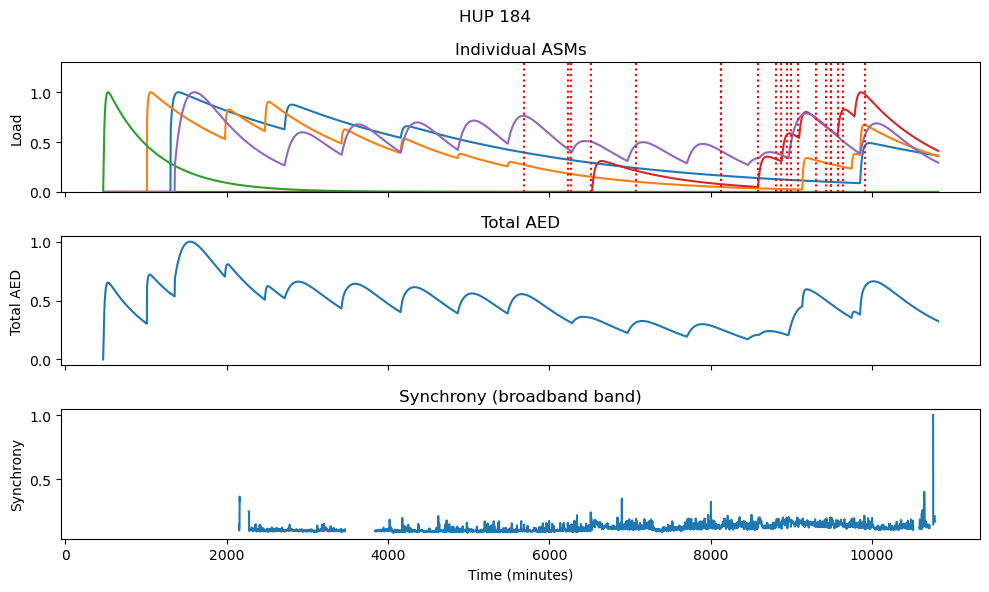

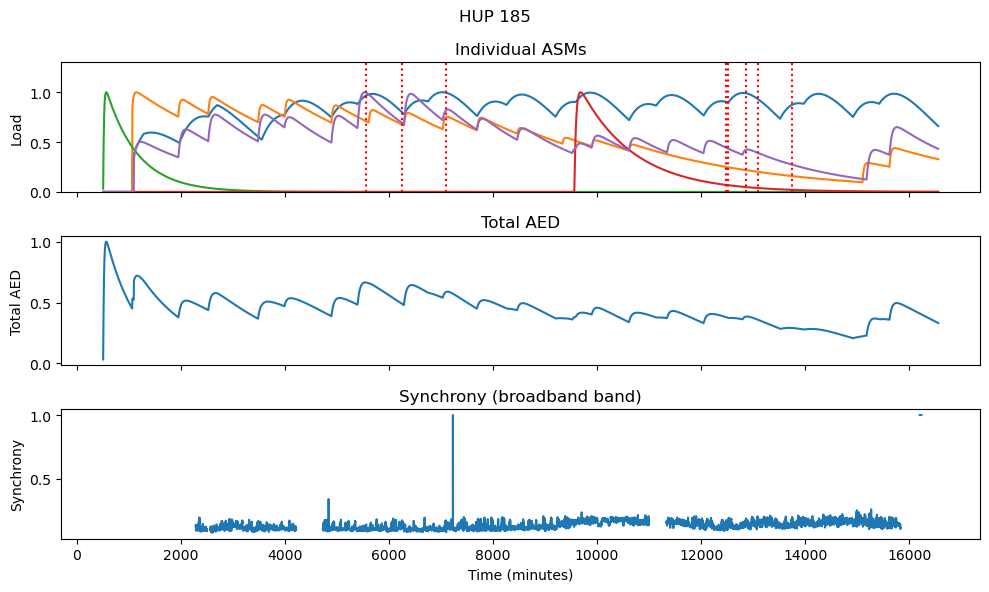

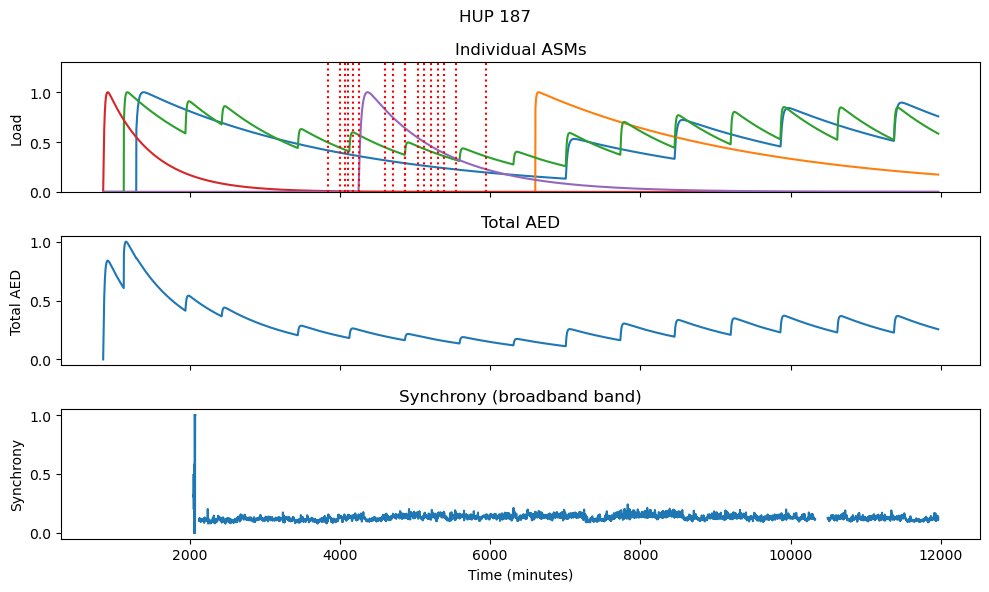

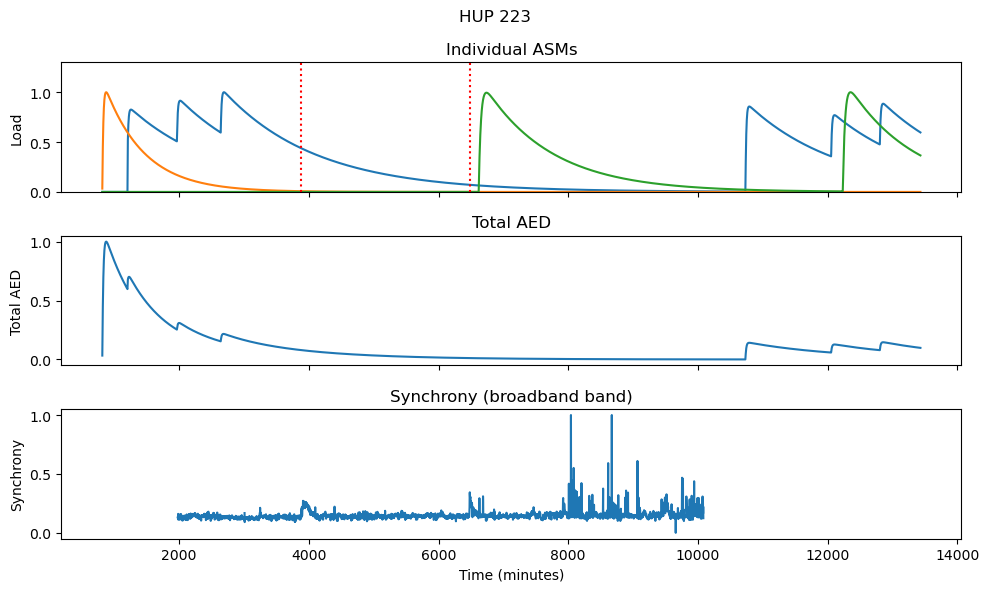

In [5]:
for patient_hup_id in completed_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    plot_stuff(hourly_patient_features_df, patient_hup_id)

In [6]:
def get_relevant_data(df, hours_before=12):
    # Find the first seizure time
    first_seizure_time = df[df["num_seizures"] >= 1]["emu_minute"].min()

    # Find the last seizure time
    last_seizure_time = df[df["num_seizures"] >= 1]["emu_minute"].max()

    # Calculate the start time for the 12-hour period before the first seizure
    start_time = (
        first_seizure_time - 2 * hours_before * 30
    )  # Since each row represents 2 minutes

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= start_time) & (df["emu_minute"] < first_seizure_time)
    ]

    # Select the data after the last seizure
    post_seizure_data = df[df["emu_minute"] > last_seizure_time]

    # Return the combined data
    return pd.concat([pre_seizure_data, post_seizure_data])


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and num_seizures columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "num_seizures",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    dfs.append(get_relevant_data(patient_features_df))


# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [7]:
# Prepare the model
model = smf.mixedlm(
    "synchrony_broadband ~ med_sum_no_lorazepam_raw",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  synchrony_broadband
No. Observations:  29393    Method:              REML               
No. Groups:        14       Scale:               0.0022             
Min. group size:   726      Log-Likelihood:      48145.2933         
Max. group size:   4561     Converged:           Yes                
Mean group size:   2099.5                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.249    0.076   3.267 0.001  0.100  0.399
med_sum_no_lorazepam_raw -0.020    0.001 -15.172 0.000 -0.023 -0.018
Group Var                 0.082    0.636                            



### Include seizure binary variable and time since last seizure. time of day, hour of emu stay

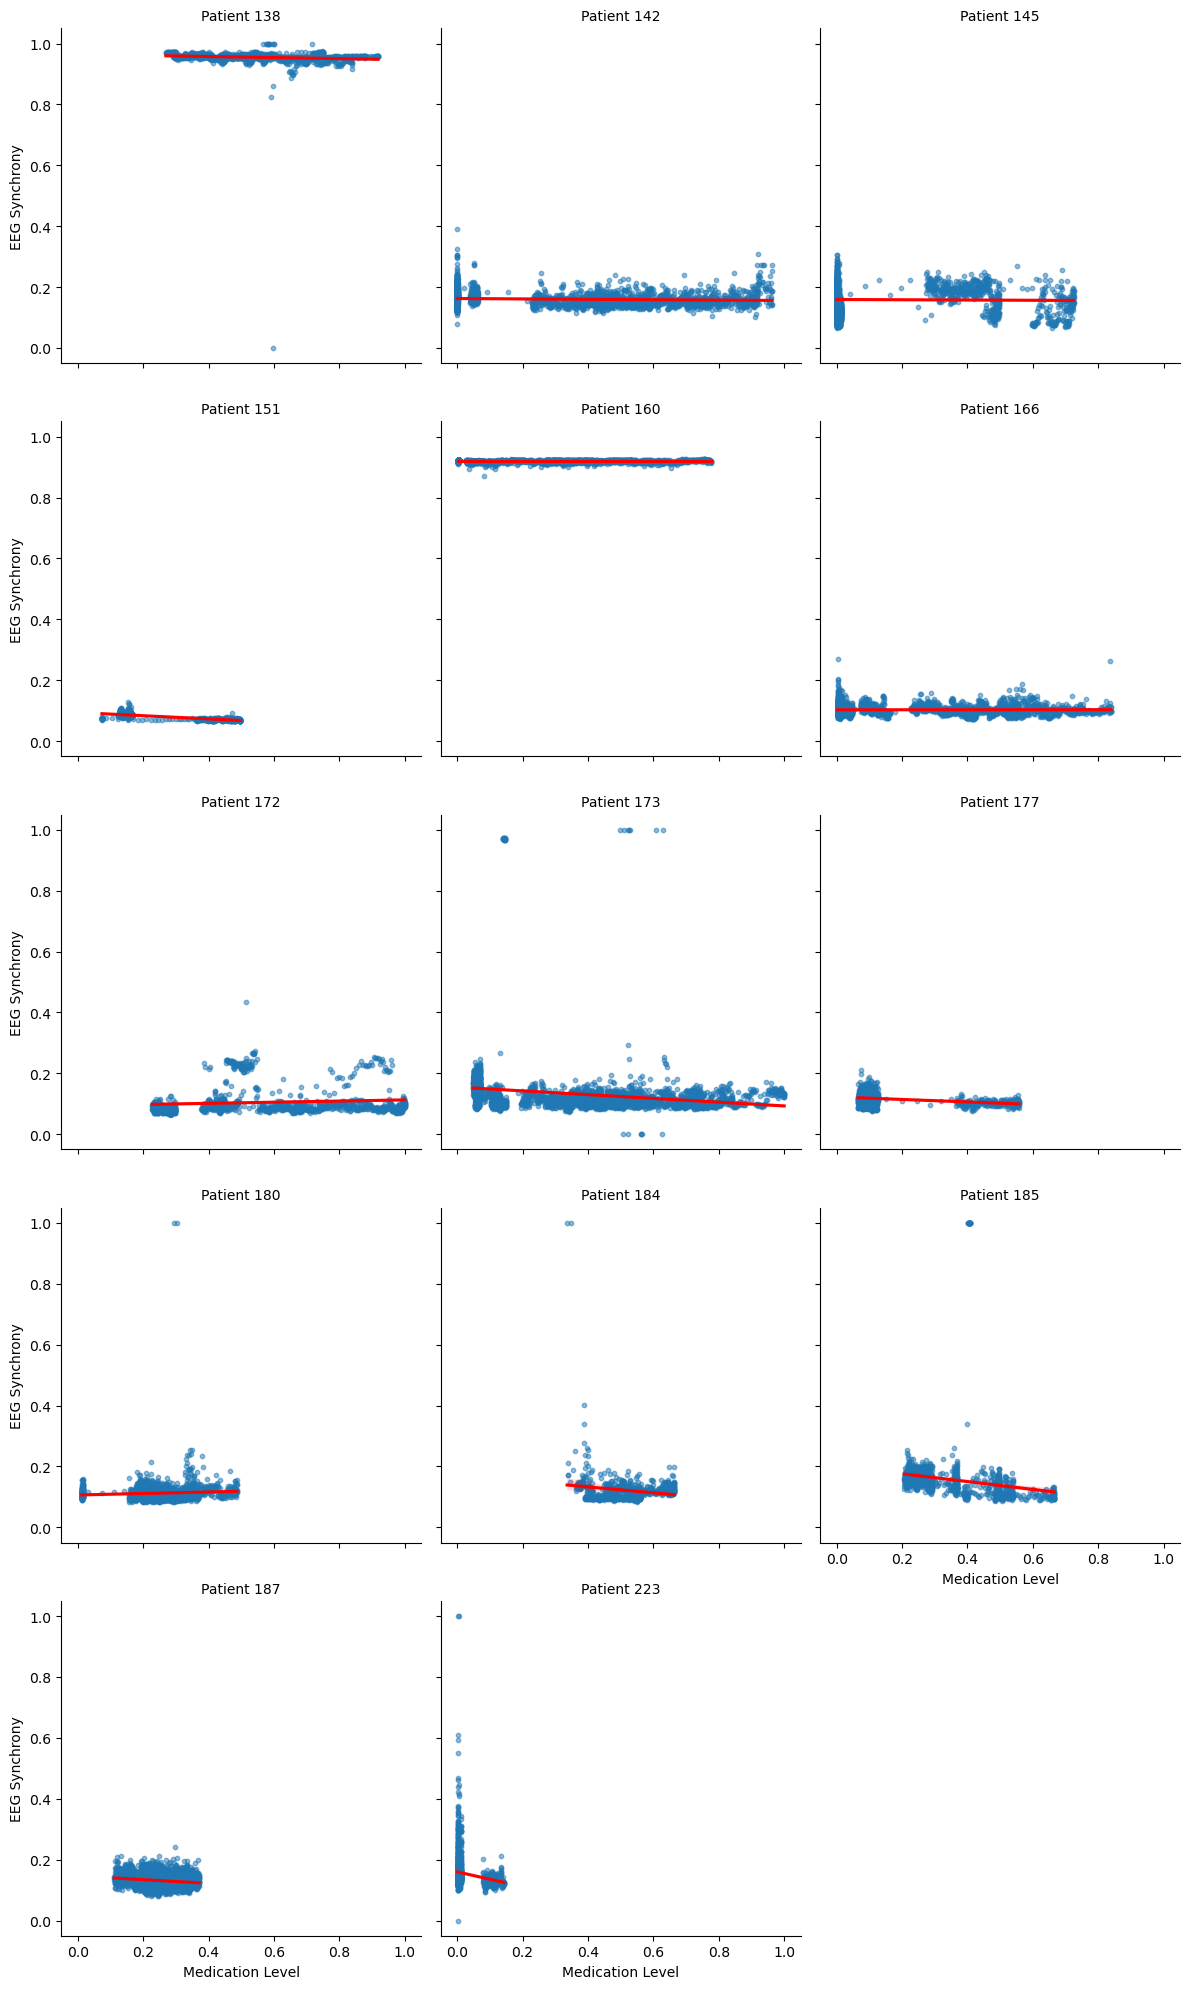

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    all_data, col="patient_hup_id", col_wrap=3, height=4, sharex=True, sharey=True
)
g = g.map(
    sns.regplot,
    "med_sum_no_lorazepam_raw",
    "synchrony_broadband",
    scatter_kws={"s": 10, "alpha": 0.5},
    line_kws={"color": "red"},
)
g.set_titles("Patient {col_name}")
g.set_axis_labels("Medication Level", "EEG Synchrony")
plt.tight_layout()
plt.show()

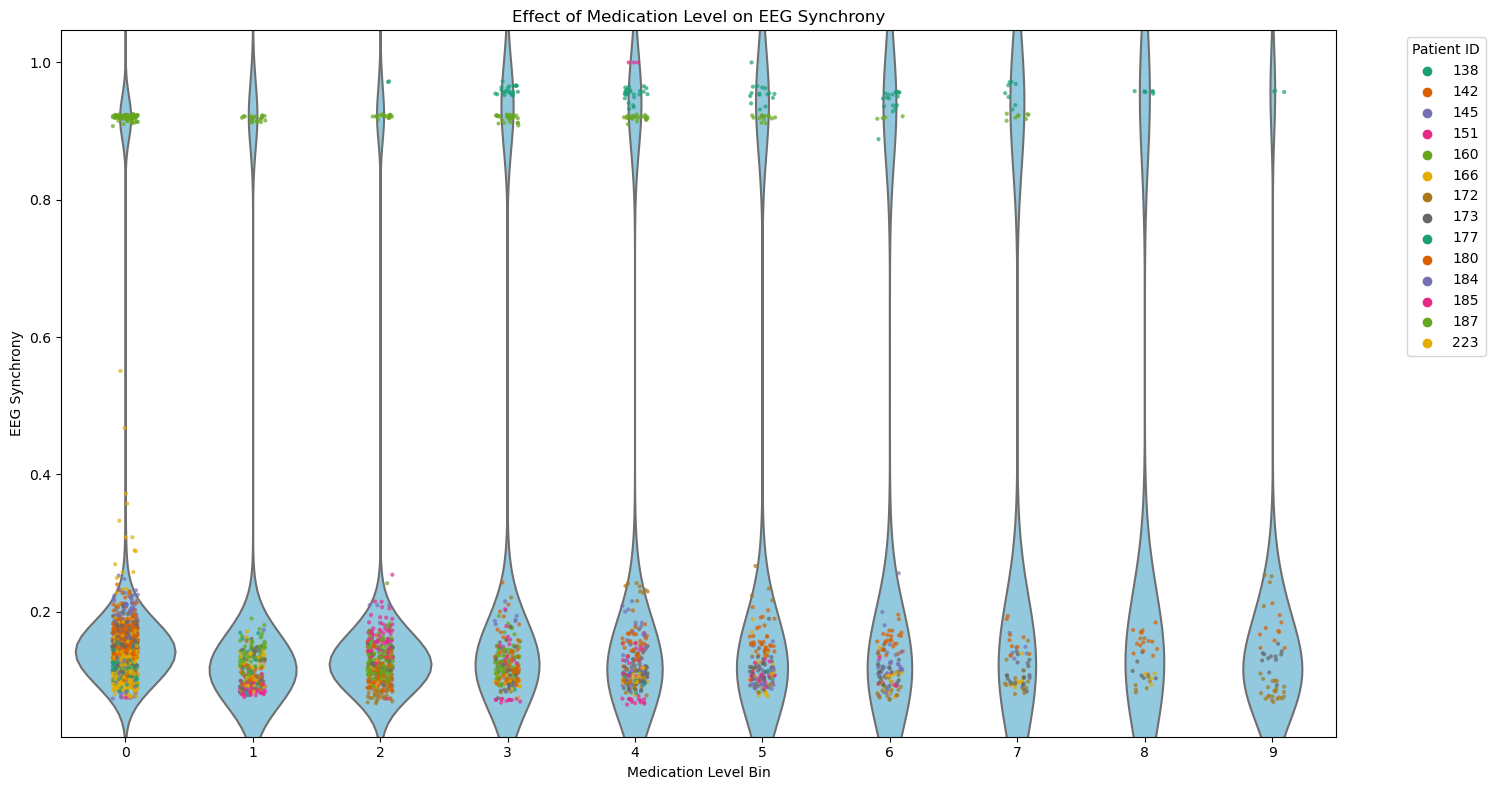

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Create a violin plot
sns.violinplot(
    data=all_data,
    x="med_level_bin",
    y="synchrony_broadband",
    color="skyblue",
    inner=None,
)

# Overlay with a strip plot for individual data points
sns.stripplot(
    data=all_data.sample(frac=0.1),  # Sample a fraction for clarity
    x="med_level_bin",
    y="synchrony_broadband",
    hue="patient_hup_id",
    size=3,
    jitter=True,
    alpha=0.7,
    palette="Dark2",
)

plt.xlabel("Medication Level Bin")
plt.ylabel("EEG Synchrony")
plt.legend(title="Patient ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Effect of Medication Level on EEG Synchrony")
plt.tight_layout()
plt.show()